## Problem Set 2: Estimating default risk using  LendingClub data

(Due: 9/20/2019)

LendingClub is a peer-to-peer lending company that has originated over $50 billion in loans. LendingClub provides a platform where borrowers can obtain loans and investors can invest in notes backed by payments of interest and principal on the loans. Interest rates are based on the likelihood that the borrower will be able to make interest payments and return the principal. Estimating an optimal interest rate and predicting the probability of default is important to both the company and investors who seek to minimize risk and maximize returns.

The goal of the exercise is to gain an understanding of how LendingClub uses data to predict probability of default. 

This exercise also domenstates:

* Importing large datasets
* Feature selection
* Data cleansing
* Setting up a machine learning classification problem

The data consists of every loan issued from 2007 to 2018. You will use the data to train and test a logistic regression model to determine probability of default. The data consists of 151 fields, including income, location, and occupation. 

Assignment:

1. Fill in Section 7 while it's demonstrated in class 
2. Perform the five tasks listed throughout the notebook and edit the appropriate blocks
3. Provide responses to the two questions at the end of the notebook

### Contents

1. Import Python libraries
    * pandas
    * numpy
    * scipy
2. Import data
    * CSV file (2GB)
3. Target variable
4. Feature selection
    * Select features available to investors
    * Remove features lacking data
5. Preprocessing
    * Convert variables to integers
    * Create dummy variables
6. Logistic regression
    * Training
    * Testing
    * Fitting the model
    * Scoring the model

### (1) Import Python libraries

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib as mpl
import time

**TASK (1): Look up and provide a brief description of the seaborn library as a comment to the right of the import statement.**

It's good practice to identify and understand any unfamilier python libraries that are used throughout a script. Searching for the library name in Google will lead you to a website with descriptions and documentaion on usage. Search "python seaborn" to find info about the seaborn library.

Remember that a python comment is added after a "#".

### (2) Import data

Data is imported from a CSV file. It is over 2GB is size, so please allow time for it to load. In the code below you'll see that the 'time' library is used to measure how long the import takes. Working with this size of file is a good example of why Python is a more useful tool than Excel in this case. 

In [2]:
start = time.time() # start timer to measure processing time
lc_df = pd.read_csv('accepted_2007_to_2018Q4.csv', low_memory=False) # load the CSV file
end = time.time() # end timer
print("Time elapsed:",(end - start),"seconds") # display time elapsed

Time elapsed: 122.95534610748291 seconds


**Task (2): Change the above code to round seconds to the nearest whole number. Refer to the documentation: https://docs.python.org/3/library/functions.html**

It's important to get familiar with using documentation to figure out how to implement functions in libraries. 

Check the size of the file to confirm it has loaded correclty. It should use over 2GB of memomry. 

In [3]:
lc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678210 entries, 0 to 678209
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 781.3+ MB


Check the first five rows:

In [4]:
lc_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,88003315,NaN,3600.0,3600.0,3600.0,36 months,12.79,120.94,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,70824148,NaN,8100.0,8100.0,8100.0,36 months,10.75,264.23,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,134123528,NaN,4850.0,4850.0,4850.0,36 months,10.07,156.66,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,51255332,NaN,15600.0,15600.0,15600.0,36 months,20.99,587.66,E,E5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,109976160,NaN,35000.0,35000.0,35000.0,60 months,9.44,734.04,B,B1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


###  (3) Target variable

The target variable is the variable that we want to predict. It is listed as "loan_status" in the dataset.

Compute the value counts for the loan_status variable. We will see that there are several responses listed in the column, but we are only going to use observations with "Fully Paid" and "Charged Off".

In [5]:
lc_df['loan_status'].value_counts(dropna=False)

Fully Paid                                             322909
Current                                                263794
Charged Off                                             80585
Late (31-120 days)                                       6315
In Grace Period                                          2484
Late (16-30 days)                                        1300
Does not meet the credit policy. Status:Fully Paid        561
Does not meet the credit policy. Status:Charged Off       240
Default                                                    12
NaN                                                        10
Name: loan_status, dtype: int64

For the loan_status target variable, we want only the rows with loans that were fully paid ('Fully Paid') or defaulted ('Charged Off'). We will remove the remaining rows in the dataset.

In [6]:
# Create a series of boolean values representing of the observations to keep
bool_keep = lc_df['loan_status'].isin(['Fully Paid', 'Charged Off'])
# Map the series of boolean values to the dataset and select only True rows
lc_df = lc_df.loc[bool_keep]

Check the value counts again and you should see only "Fully Paid" and "Charged Off" listed:

In [7]:
lc_df['loan_status'].value_counts()

Fully Paid     322909
Charged Off     80585
Name: loan_status, dtype: int64

**TASK (3): In the cell below, implement a pandas attribute that will tell you the number of rows and columns in the dataset. Use the pandas attribute documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html**

### (4) Feature selection

Currently the dataset has 151 features. We will remove features with substantial missing values and features that would not be available to investors.

We will drop features missing more than 20% of its data. Of the remaining features, we will then select the ones that would be available to investors prior to financing the loan.

In [8]:
null_values = lc_df.isnull()
percent_null = null_values.mean()
percent_null = percent_null.sort_values(ascending=False)

Text(0, 0.5, 'features')

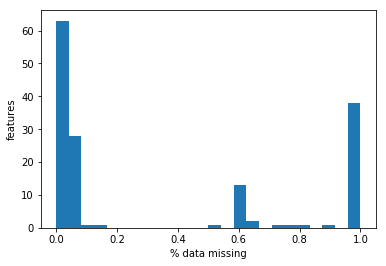

In [9]:
# Visualize the distribution of missing data percentages
plt.figure()
percent_null.plot.hist(bins=24)
plt.xlabel('% data missing')
plt.ylabel('features')

Looks like there are several features that are missing substantial amounts of data. Let's get rid of features that have more than 20 percent of the data missing. The following code selects and stores in alphabetical order the variables with more than 20% of values missing. The features are stored in the "features_drop" variable. 

In [10]:
percent_null = percent_null[percent_null > 0.2]
features_drop = sorted(percent_null[percent_null > 0.2].index)

**TASK (4): Show the number of features with more than 20% values missing, which are stored in the "features_drop" variable. Use the "len()" function, which is a Python built-in function. Refer to the docs: https://docs.python.org/3/library/functions.html**

The features are removed using the pandas 'drop' method:

In [11]:
lc_df.drop(labels=features_drop, axis=1, inplace=True)

Of the remaining features, the following is a list of the features that would be available for financing decisions. These are the features to use in the model and should remain in the dataset.

In [12]:
features_keep = [
    'addr_state', 'annual_inc', 'application_type', 'fico_range_high', 
    'fico_range_low', 'home_ownership', 'initial_list_status', 
    'installment', 'int_rate', 'loan_amnt', 'loan_status', 
    'open_acc', 'pub_rec', 'purpose', 'revol_bal', 
    'sub_grade', 'term', 'total_acc', 'verification_status'
    ]

The following code makes a list of the features we do not want to use in the model. It then drops those features from the dataset.

In [13]:
features_drop = [x for x in lc_df.columns if x not in features_keep]
lc_df.drop(labels=features_drop, axis=1, inplace=True)

### (5) Preprocessing

Sometimes data is in a format that won't be compatible with a model. For example, if we look at the "term" column, we see that the data is listed as a string. It needs to be converted into an integer. 

In [14]:
lc_df['term'].head()

0     36 months
1     36 months
3     36 months
7     60 months
9     36 months
Name: term, dtype: object

The following code converts the "term" data to the integer data type.

In [15]:
lc_df['term'] = lc_df['term'].apply(lambda s: np.int8(s.split()[0]))

String data throughout the dataset needs to be converted into a numberical form. For categortical data we wse dummy variables. For example, the data "loan_status" target feature needs to be converted into 0s and 1s, with 1 representing a "Charged Off" observation.

Let's look at a sample of the "loan_status" data in its current format:

In [16]:
lc_df['loan_status'].sample(10)

453536     Fully Paid
615990     Fully Paid
101683    Charged Off
64282      Fully Paid
528778     Fully Paid
314664    Charged Off
18760      Fully Paid
529727     Fully Paid
206476     Fully Paid
501067     Fully Paid
Name: loan_status, dtype: object

The following code will convert the string data to integer form:

In [17]:
lc_df['charged_off'] = (lc_df['loan_status'] == 'Charged Off').apply(np.uint8)
lc_df.drop('loan_status', axis=1, inplace=True)

Again, look at a sample to see the transformation:

In [18]:
lc_df['charged_off'].sample(10)

495784    0
411589    0
55344     0
436853    0
25845     1
315071    0
268347    0
403661    1
406788    1
600670    1
Name: charged_off, dtype: int64

The following code creates dummy variables for the the remaining categorical features in the dataset:

In [19]:
lc_df = pd.get_dummies(lc_df, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type'], drop_first=True)

Now the dataset is ready to be used in a model.

### (6) Logistic regression

The first part of building a logistic regression model is to partition the data into a training set and a test set. The training set will comprise of 80% of the observations and the test set will comprise of 20% of the observations.

Import the appropriate library:

In [20]:
from sklearn.model_selection import train_test_split

Assign a training set and a test set to new variables:

In [21]:
train, test = train_test_split(lc_df, test_size=0.2)

Split each set into x and y components:

In [22]:
test_data = test.drop(['charged_off'], axis=1)

In [23]:
y_test_data = test['charged_off']

In [24]:
y_train_data = train['charged_off']

In [25]:
x_train_data = train.drop(['charged_off'], axis=1)

**TASK (5): Using prior code examples as reference, in the cell below, show that the variable "y_test_data" contains the correct binary data representing whether a loan was charged off or not. (It's good practice to check that the correct data is stored)**

The second part of building the logistic regression model is the process of fitting the model with training data and then testing its performance with the test data. Logistic regression is just one type of machine learning algorithm used in classification problems. Others include SVM, decision trees, etc. 

In [26]:
# 1. Import the model
from sklearn.linear_model import LogisticRegression

In [27]:
# 2. Make an instance of the model
logreg_model = LogisticRegression(class_weight='balanced')

In [28]:
# 3. Training the model
logreg_model.fit(x_train_data, y_train_data)

C:\Users\andre\OneDrive\Documents\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [29]:
# 4. Predict from test data
predictions = logreg_model.predict(test_data) # the predictions in binary form
predictions_probs = logreg_model.predict_proba(test_data) # the predictions as probabilities

Show an array of predictions:

In [30]:
predictions

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

Show an array of prediction probabilities:

In [31]:
predictions_probs

array([[0.29016075, 0.70983925],
       [0.39315653, 0.60684347],
       [0.82279492, 0.17720508],
       ...,
       [0.43104708, 0.56895292],
       [0.58138567, 0.41861433],
       [0.3817149 , 0.6182851 ]])

We will measure performance using the accuracy of the model.

accuracy = correct predictions / total number of data points

In [32]:
# The score method to return the accuracy of the model
score = logreg_model.score(test_data, y_test_data)

In [33]:
print(score)

0.6635150373610578


The result is the percentage of observations that your model correctly predicted. 

### Questions

1. Assume that you built a program that was nearly 100% accurate at predicting default. How would that benefit the borrowers and lenders using LendingClub? How would LendingClub's business improve?

2. In the logistic regression part, explain why we initially needed to split the data into two different sets. Which set contains more observations? Which set was used to fit the model?